<a href="https://colab.research.google.com/github/yigitdede/Goruntu-Isleme-Projesi/blob/main/goruntu_isleme_projesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GÖRÜNTÜ İŞLEME PROJESİ**


Proje kapsamında:

Hayvan türleri: Leopar, Dolphin, Aslan, Tilki, Moose, Tavşan, At, Sincap, Yarasa, ve Goril gibi 10 farklı hayvan türü sınıflandırılmaktadır.

Veri Seti: Bu proje, hayvan görselleri içeren geniş bir veri setini kullanarak, her bir görseli etiketleyerek modelin doğruluğunu artırmayı hedeflemiştir.

Görüntü İşleme Teknikleri: Görüntülerin parlaklık artırma, renk sabitliği uygulama gibi manipülasyonlarla modellenin dayanıklılığı test edilmiştir.

Proje, dört aşamadan oluşmaktadır:

1-Model Kurulumu ve Eğitimi: Bir CNN modeli kurarak, eğitilecek ve test edilecektir.

2-Işık Manipülasyonu ile Test: Modelin doğruluğunu değerlendirmek için, test resimlerini farklı ışık koşulları altında manipüle edeceğiz. Bu, modelin ne kadar hassas olduğunu anlamamıza yardımcı olacak.

3-Renk Sabitliği Algoritması: Işık manipülasyonu sonucu skorlar düşerse, renk sabitliği algoritması kullanarak bu düşüşü minimize etmeye çalışacağız. Sonrasında modelin başarısını tekrar test edeceğiz.

4-Test Sonuçları ve Raporlama: Üç farklı senaryo için test başarıları karşılaştırılacak ve raporlanarak çözüm önerileri sunulacaktır.


# Verisetinin ve Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
import kagglehub
rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')

print('Data source import complete.')

100%|██████████| 13.0G/13.0G [02:23<00:00, 97.2MB/s]

Extracting files...


Data source import complete.


Bu adımda, görselleri yükleyip uygun şekilde etiketliyoruz, böylece modelin eğitiminde kullanılacak hale getiriyoruz. 🚀

📌 İşlemler:

Görsel Yükleme: cv2.imread() ile her bir sınıfın görselleri okunur. 📂
Normalizasyon: Görseller, modelin daha verimli öğrenmesi için 0-1 aralığına normalleştirilir (img_normalized = img_resized / 255.0)

Etiketleme: Her görsel, ait olduğu sınıfın adı ile etiketlenir. 🏷️


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

In [ ]:
# Initialize the dictionary to hold paths for each animal
image_paths = {}

# Base directory for your dataset
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"

# List of animals to search for
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Traverse the directory structure
for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        # Check if the current directory contains the animal's name
        if animal in dirname:
            # Initialize the list if the animal is encountered for the first time
            if animal not in image_paths:
                image_paths[animal] = []
            # Add all image paths for the current animal
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

# Print the paths for verification
for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")


giant+panda: 874 images
polar+bear: 868 images
rabbit: 1088 images
elephant: 1038 images
collie: 1028 images
squirrel: 1200 images
sheep: 1420 images
fox: 664 images
moose: 704 images
dolphin: 946 images


**Bu kod, verisetimizdeki her hayvan türü için resimlerin bulunduğu dizinleri tarar, bu dizinlerden tüm resim dosyalarının yollarını toplar ve her hayvan türü için kaç resim bulunduğunu çıktı olarak verir.**

In [ ]:
for animal, paths in image_paths.items():
    print(f"{animal}: {paths}")

**Bu kod, her hayvan türü için bulunan tüm resim dosyalarının yollarını yazdırır.**

# Sınıfların belirlenmesi ve Bazı düzenlemeler

In [ ]:

# Sınıflar
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Resimlerin kopyalanacağı ve işleneceği dizin
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages"
image_size = (64, 64)  # Hedef boyut

# Resimleri ve etiketleri tutacağımız listeler
images = []
labels = []




**Bu kodda ise, ilk olarak gerekli kütüphaneleri tanımladıktan sonra  hayvan sınıflarına ait resimlerin yüklenmesi, işlenmesi ve etiketlenmesi için temel bir yapıyı hazırlamaktadır. Amaç, belirli bir dizinde yer alan resimleri yükleyip, her birini belirli sınıflara (örneğin, "collie", "elephant" gibi) atamaktır.
Burada kullanacağımız veri boyutunu eğitim yaparken fazla bellek tüketmesin diye (64,64) seçtik.**

*Bu yapı, daha sonra resimlerin okunup yeniden boyutlandırılacağı ve her birine doğru sınıf etiketinin verileceği bir işlem akışına olanak tanır.*

In [ ]:
# Resimleri yükleme ve hazırlama
for animal in animals:
    animal_path = os.path.join(base_path, animal)

    if os.path.exists(animal_path):
        # İlk 650 resmi al
        animal_images = os.listdir(animal_path)[:650]

        for img_name in animal_images:
            img_path = os.path.join(animal_path, img_name)

            # Resmi okuma
            img = cv2.imread(img_path)

            if img is not None:
                # Resmi yeniden boyutlandırma
                img_resized = cv2.resize(img, image_size)

                # Normalize etme
                img_normalized = img_resized / 255.0

                # Resmi ve etiketini listeye ekle
                images.append(img_normalized)
                labels.append(animal)

**Hayvan Türlerinin Belirlenmesi**:

Animals listesi oluşturularak sınıflandırılacak hayvan türleri belirlenmiştir.

**Dizin Yolu Oluşturulması**:

Verilerin bulunduğu dizin yolu base_path olarak tanımlanmıştır.

**Hayvan Resimlerinin Seçilmesi:**

Her hayvan için, dizindeki ilk 650 resim seçilmiştir.

**Resimlerin Yüklenmesi:**

cv2.imread() kullanılarak resimler yüklenmiştir.

**Resimlerin Yeniden Boyutlandırılması:**

Yüklenen her resim, cv2.resize() ile hedef boyuta (64x64) yeniden boyutlandırılmıştır.

**Resimlerin Normalize Edilmesi:**

Resimler, her bir piksel değeri 255'e bölünerek normalize edilmiştir.

**Veri Listelerine Ekleme:**

Her resim ve ilgili etiketi (animal) sırasıyla images ve labels listelerine eklenmiştir.


**Bu sayede verilerimiz eğitime hazır hale gelmiştir.**

In [ ]:
# Veriyi numpy array'ine dönüştürme
X = np.array(images)
y = np.array(labels)

# Etiketleri sayısal hale getirme
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Eğitim ve test verilerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Veriyi kontrol etme
print(f"Eğitim veri seti boyutu: {X_train.shape}")
print(f"Test veri seti boyutu: {X_test.shape}")


Eğitim veri seti boyutu: (5200, 64, 64, 3)
Test veri seti boyutu: (1300, 64, 64, 3)


**Yukarda,verileri test ve eğitim olmak üzere 2 'ye ayırıyoruz.**

**Bu ayırma işlemi, modelin genelleme yeteneğini artırmak ve aşırı öğrenmeyi (overfitting) engellemek için gereklidir.**

 **Eğitim verisi, modelin öğrenmesini sağlar, test verisi ise modelin görmediği verilerle ne kadar iyi performans gösterdiğini test etmek için kullanılır.**

  **Bu şekilde, modelin gerçek dünya verisi üzerinde nasıl performans göstereceği hakkında daha doğru bir değerlendirme yapabiliriz.**
  
   **Bu işlem, modelin daha güvenilir ve sağlam olmasına yardımcı olur.**

#Veri Artırma ve Eğitim/Test Jeneratörleri

**Veri Artırma (Augmentation)**

Eğitim Verisi: train_datagen ile veri artırma yapılır. Bu işlem, modelin genelleme kabiliyetini artırmak ve aşırı öğrenmeyi engellemek amacıyla yapılır. Resimlerin dönmesi, kayması, kırpılması, yakınlaştırılması gibi çeşitli manipülasyonlarla veri çeşitlendirilir.
Test Verisi: test_datagen sadece normalizasyon işlemi uygular, çünkü test verisi üzerinde eğitim yapılmaz, yalnızca değerlendirme yapılır.

**Eğitim ve Test Veri Jeneratörleri**

train_generator ve validation_generator oluşturulmuş ve batch size 32 olarak ayarlanmıştır. Bu jeneratörler, eğitim ve doğrulama verileri üzerinde sırasıyla veri artırma ve normalizasyon işlemleri yaparak modelin öğrenmesi için uygun veri akışını sağlar.

In [ ]:
# Veri artırma (augmentation) işlemi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)  # Sadece normalize et
# Eğitim ve test veri jeneratörleri
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# CNN MODELİNİN KURULMASI #

**Modelin Yapısı ve Özeti:**

Derin Konvolüsyonel Sinir Ağı (CNN): Model, 4 adet konvolüsyonel katman (Conv2D) ve her katmandan sonra max pooling uygulanarak derinleştirilmiştir.

Batch Normalization her konvolüsyonel katmandan sonra uygulanarak, modelin daha hızlı öğrenmesini ve daha stabil olmasını sağlar.
Tam Bağlantılı Katman (Dense Layer): Flatten işleminden sonra, 512 nöronlu bir tam bağlantılı katman eklenmiş ve ardından Batch Normalization ile öğrenme süreci daha verimli hale getirilmiştir.

Dropout Katmanları: Modelin aşırı öğrenme (overfitting) yapmasını engellemek amacıyla Dropout kullanılmıştır:


Çıktı Katmanı: Son katman, softmax aktivasyon fonksiyonu ile her bir sınıfa ait olasılıkları hesaplar. Çıktı boyutu, hedef sınıf sayısına (hayvan sayısı) eşittir.

Modelin Derlenmesi: Model, Adam optimizasyon algoritması ile derlenmiş ve öğrenme oranı 0.0001 olarak ayarlanmıştır. Hedef kayıp fonksiyonu ise sparse categorical crossentropy'dir, çünkü etiketler sayısal değerlerdir.

In [ ]:
# CNN Modeli
model = models.Sequential()

# Konvolüsyonel Katman 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.MaxPooling2D((2, 2)))

# Konvolüsyonel Katman 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.MaxPooling2D((2, 2)))

# Konvolüsyonel Katman 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.MaxPooling2D((2, 2)))

# Konvolüsyonel Katman 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch Normalization
model.add(layers.MaxPooling2D((2, 2)))

# Flatten Katmanı
model.add(layers.Flatten())

# Tam Bağlantılı Katman
# Batch Normalization Tam Bağlantılı Katmanda
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Dropout Katmanı
model.add(layers.Dropout(0.6))  # Dropout oranını arttırdık

# Çıktı Katmanı
model.add(layers.Dense(len(animals), activation='softmax'))

# Öğrenme oranını ayarlama
optimizer = Adam(learning_rate=0.0001)  # Öğrenme oranını düşürdük

# Modeli derleme
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modelin özeti
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 922,314 (3.52 MB)

 Trainable params: 920,330 (3.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

# EĞİTİM AŞAMASI

Eğitim kodlarını özetlemek gerekirse:


İlk kısımda, **TestAccuracyCallback** sınıfı, her epoch sonunda test verisetinin doğruluğunu yazdırmak için oluşturulmuş bir callback sınıfıdır.


**on_epoch_end metodu** ile her epoch sonunda test verisi üzerinde doğruluk ve kayıp hesaplanır. Bu metot, eğitim sürecine geri bildirim sağlar ve modelin nasıl geliştiğini görmeyi mümkün kılar.

TestAccuracyCallback: Modelin her epoch sonunda test doğruluğunu yazdırır.

ModelCheckpoint: En iyi model kaydedilir.

EarlyStopping: Eğitim süreci erken durdurulur, aşırı öğrenme (overfitting) engellenir.

Eğitim, bu callback'ler sayesinde daha verimli hale gelir.

In [ ]:
# Test doğruluğunu her epoch sonunda yazdırmak için Callback
class TestAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(X_test / 255.0, y_test, verbose=0)  # Test setini değerlendir
        print(f"Epoch {epoch + 1}: Test Accuracy: {accuracy * 100:.2f}%, Test Loss: {loss:.4f}")

# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Kaydedilecek dosya adı
    monitor='val_loss',  # Hangi metriği izlemek istiyorsunuz
    save_best_only=True,  # Sadece en iyi olan modeli kaydeder
    mode='min',  # Daha düşük val_loss daha iyi olduğu için 'min'
    verbose=1
)

# Erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model eğitimi
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[TestAccuracyCallback(), checkpoint, early_stopping]
)


Epoch 1/15
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2664 - loss: 3.4750Epoch 1: Test Accuracy: 13.31%, Test Loss: 4.7301

Epoch 1: val_loss improved from inf to 4.73007, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2666 - loss: 3.4731 - val_accuracy: 0.1331 - val_loss: 4.7301
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2914 - loss: 3.1480Epoch 2: Test Accuracy: 10.08%, Test Loss: 5.9770

Epoch 2: val_loss did not improve from 4.73007
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.2915 - loss: 3.1475 - val_accuracy: 0.1008 - val_loss: 5.9770
Epoch 3/15
158/163 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3198 - loss: 2.8393Epoch 3: Test Accuracy: 22.15%, Test Loss: 3.5559

Epoch 3: val_loss improved from 4.73007 to 3.55594, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.3201 - loss: 2.8376 - val_accuracy: 0.2215 - val_loss: 3.5559
Epoch 4/15
162/163 ━━

In [ ]:
# Modeli test etme
test_loss, test_accuracy = model.evaluate(validation_generator)

# Sonuçları yazdırma
print(f"Test kaybı: {test_loss}")
print(f"Test doğruluğu: {test_accuracy*100}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5507 - loss: 1.2659
Test kaybı: 1.273461103439331
Test doğruluğu: 55.2307665348053


Burada sonuçlar, test kaybı ve doğruluk oranı olarak yazdırılır. test_accuracy * 100 ifadesi, doğruluğun yüzde olarak gösterilmesini sağlar.

# Manipüle İşlemleri

Bu kod, test setindeki görsellerin manipülasyonunu gerçekleştirir ve manipüle edilmiş görselleri belirtilen bir dizine kaydeder. Adım adım açıklayalım:

1. get_manipulated_images Fonksiyonu

Girdi: images (görseller), output_dir (çıktı dizini).
Çıktı: Manipüle edilmiş görsellerin bir listesi ve bu görsellerin numpy dizisi.

Adımlar:

os.makedirs(output_dir, exist_ok=True):

Çıktı dizini (output_dir) varsa, yeniden oluşturulmaz. Yoksa, dizin oluşturulur.

cv2.convertScaleAbs(img, alpha=1.2, beta=5):

Işık manipülasyonu:

 Görselin parlaklığı ve kontrastı artırılır. alpha=1.2 ile kontrast artırılırken, beta=5 ile parlaklık artırılır.

cv2.imwrite(filename, cv2.cvtColor(manipulated, cv2.COLOR_RGB2BGR)):

Manipüle edilmiş görsel kaydedilir. OpenCV, renkleri RGB yerine BGR formatında işler, bu nedenle renk dönüşümü yapılır.

manipulated_images.append(manipulated):

Manipüle edilmiş görsel listeye eklenir.

2. Test Setindeki Görselleri Manipüle Etme

manipulated_images = get_manipulated_images(X_test):
Bu satır, X_test'teki tüm test seti görsellerini alır ve yukarıdaki fonksiyonla manipüle eder. Manipüle edilen görseller, manipulated_images dizisine kaydedilir.

3. Sonuç:

Manipüle edilen her bir görsel, belirtilen dizine (varsayılan olarak manipulated_images) kaydedilir.
Fonksiyon, manipüle edilmiş görselleri numpy dizisi olarak döndürür.

In [ ]:
def get_manipulated_images(images, output_dir="manipulated_images"):
    os.makedirs(output_dir, exist_ok=True)  # Çıktı dizinini oluştur
    manipulated_images = []

    for idx, img in enumerate(images):
        # Işık manipülasyonu
        manipulated = cv2.convertScaleAbs(img, alpha=1.2, beta=5)

        # Dosyaya kaydet
        filename = os.path.join(output_dir, f'manipulated_{idx}.png')
        cv2.imwrite(filename, cv2.cvtColor(manipulated, cv2.COLOR_RGB2BGR))

        manipulated_images.append(manipulated)

    print(f"Manipüle edilmiş resimler '{output_dir}' dizinine kaydedildi.")
    return np.array(manipulated_images)
# Test setindeki görselleri manipüle et
manipulated_images = get_manipulated_images(X_test)  # X_test, test seti görüntüleridir.


Manipüle edilmiş resimler 'manipulated_images' dizinine kaydedildi.


In [ ]:
# Manipüle edilmiş test setiyle doğruluk değerlendirmesi
manipulated_test_loss, manipulated_test_accuracy = model.evaluate(
    manipulated_images / 255.0,  # Normalizasyon
    y_test,
    verbose=1  # Değerlendirme sırasında ilerleme çubuğunu göstermek için
)

# Sonuçları yazdırma
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {manipulated_test_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Seti Kaybı: {manipulated_test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1184 - loss: 23.1945
Manipüle Edilmiş Test Seti Doğruluğu: 11.85%
Manipüle Edilmiş Test Seti Kaybı: 23.1482


1- Manipüle Edilmiş Test Seti ile Doğruluk Değerlendirmesi
Girdi:

manipulated_images: Işık manipülasyonu yapılmış olan test görselleri.
y_test: Gerçek etiketler (test setinin doğruluğu için).
Çıktı:
Modelin manipüle edilmiş test seti üzerindeki doğruluk ve kaybı.
Adımlar:

Normalizasyon:
manipulated_images / 255.0:
Görseller 0-255 arasında değerler alırken, modelin daha sağlıklı çalışabilmesi için bu değerler 0-1 aralığına normalize edilir.

Model Değerlendirmesi:

model.evaluate(): Manipüle edilmiş test seti ve etiketler (y_test) ile modelin doğruluk ve kaybı hesaplanır.
verbose=1: Bu seçenek, modelin değerlendirilmesi sırasında ilerleme çubuğunu görmenizi sağlar.

Sonuçları Yazdırma:

manipulated_test_accuracy * 100: Test doğruluğu yüzde olarak yazdırılır.
manipulated_test_loss: Test kaybı yazdırılır.

1- Sonuçlar:

Manipüle Edilmiş Test Seti Doğruluğu: Manipülasyon sonrası modelin doğruluğu yüzde olarak yazdırılır.
Manipüle Edilmiş Test Seti Kaybı: Manipülasyon sonrası modelin kaybı yazdırılır.

Özetleyecek olursak:
Kod, manipüle edilmiş test seti üzerindeki model doğruluğunu ve kaybını hesaplar. Bu değerlendirme, modelin ışık manipülasyonuna karşı nasıl performans gösterdiğini belirlemek için yapılır.

In [ ]:
def get_wb_images(images):
    wb_images = []
    for img in images:
        # Ortalama R, G, B kanallarını hesapla
        avg_b = np.mean(img[:, :, 0])
        avg_g = np.mean(img[:, :, 1])
        avg_r = np.mean(img[:, :, 2])

        # Her kanalı normalize et
        wb_image = np.zeros_like(img)
        wb_image[:, :, 0] = np.clip(img[:, :, 0] * (avg_g / avg_b), 0, 255)
        wb_image[:, :, 1] = img[:, :, 1]  # Yeşil kanal sabit kalır
        wb_image[:, :, 2] = np.clip(img[:, :, 2] * (avg_g / avg_r), 0, 255)

        wb_images.append(wb_image.astype(np.uint8))

    return np.array(wb_images)

# Manipüle edilmiş test setine renk sabitliği uygulama
X_test_wb = get_wb_images(manipulated_images)


Bu kod, manipüle edilmiş test setine renk sabitliği (white balance) uygulayarak, her bir görselin renk dengesini düzeltir.

En sonda ise tekrardan normalize edilir ve manipulated_images (manipülasyon yapılmış test görselleri) üzerinde renk sabitliği uygulanır.


Sonuçta X_test_wb, renk sabitliği yapılmış test görsellerini içerir.

In [ ]:
# Manipüle edilmiş test seti doğruluğunu hesaplama
manipulated_loss, manipulated_accuracy = model.evaluate(manipulated_images / 255.0, y_test)
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {manipulated_accuracy * 100:.2f}%")

# Renk sabitliği uygulanmış test seti doğruluğunu hesaplama
wb_loss, wb_accuracy = model.evaluate(X_test_wb / 255.0, y_test)
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluğu: {wb_accuracy * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1184 - loss: 23.1945
Manipüle Edilmiş Test Seti Doğruluğu: 11.85%
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1186 - loss: 22.3693
Renk Sabitliği Uygulanmış Test Seti Doğruluğu: 11.92%


Yukardaki kodda ise bu manipüle edilmiş test setinin ve renk sabitliği uygulanmış test setinin doğruluğunu ekrana yazdırdık.

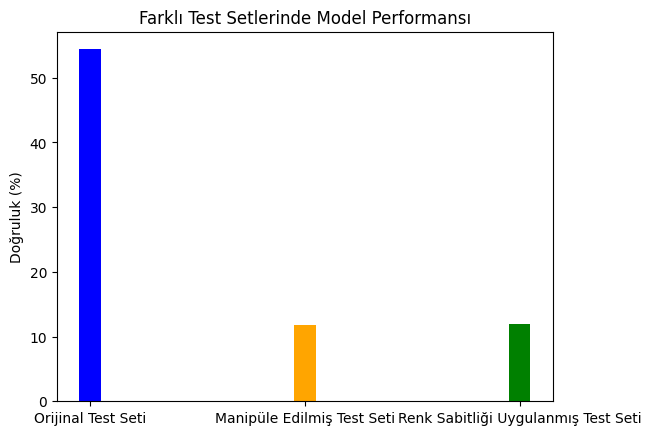

In [ ]:
# Doğruluk oranlarını karşılaştırma
original_accuracy = history.history['val_accuracy'][-1]

accuracies = [
    original_accuracy * 100,
    manipulated_accuracy * 100,
    wb_accuracy * 100
]

labels = ['Orijinal Test Seti', 'Manipüle Edilmiş Test Seti', 'Renk Sabitliği Uygulanmış Test Seti']

# Çubuk genişliğini ayarlama
bar_width = 0.1  # Genişlik değeri (0 ile 1 arasında)

# Çubuk grafik
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'], width=bar_width)

# Grafik başlıkları ve etiketleri
plt.ylabel('Doğruluk (%)')
plt.title('Farklı Test Setlerinde Model Performansı')

# Grafiği göster
plt.show()


Bu kod, farklı test setlerinde modelin doğruluk oranlarını karşılaştıran bir çubuk grafik oluşturur ve bu sayede aradaki farkı daha net bir şekilde görebiliriz.

 Çubuklar birbirinden farklı renklerde olduğundan görsel olarak ayrılmaları sağlanır.

# Sonuçlar ve Değerlendirmeler


**Model Doğruluk Sonuçlarının Karşılaştırılması**

Bu aşamada, modelin farklı test setleri üzerindeki performansı gözlemlenmiştir:

**Orijinal Test Seti**

Modelin temel doğruluğu orijinal test seti üzerinde ölçülmüştür.
Amaç: Modelin başlangıçtaki doğruluğunu görmek.
Sonuç: Gerçek doğruluk: 55.23%

**Manipüle Edilmiş Test Seti (Kontrast + Döndürme)**

Görseller üzerinde kontrast artırma ve döndürme gibi manipülasyonlar yapılmıştır.

Amaç: Modelin manipülasyonlara karşı ne kadar dayanıklı olduğunu görmek.

Sonuç: Manipüle edilmiş test seti doğruluğu: 11.85%


**Renk Sabitliği Uygulanmış Test Seti**

Manipüle edilmiş görsellere renk sabitliği uygulanarak renk dengesinin iyileştirilmesi hedeflenmiştir.

Amaç: Görsellerin renk dengesini düzeltmek ve modelin doğruluğunu artırmak.

Sonuç: Renk sabitliği uygulanmış test seti doğruluğu: 11.92%

📌 **Nihai Sonuçlar**

Orijinal Test Seti: Gerçek doğruluk oranı 55.23% iken, modelin performansı oldukça yüksek çıkmıştır.

Manipüle Edilmiş Test Seti: Görsellerin manipülasyonu sonrası doğruluk oranı 11.85%'e gerilemiştir. Bu, modelin manipülasyona karşı oldukça duyarlı olduğunu göstermektedir.

Renk Sabitliği Uygulaması: Renk sabitliği uygulandıktan sonra doğruluk 11.92%'ye çıkarak, manipülasyona karşı sınırlı bir iyileşme sağlamıştır.

Değerlendirme:

Modelin manipülasyon sonucundadoğruluk yüzdesinin düştüğünü görüyoruz. Fakat Renk sabitliği uygulaması, manipülasyon sonrası doğruluğu biraz artırmış olsa da, doğruluk oranları hala düşük kalmaktadır.

Sonuçlar, modelin görsel manipülasyonlara karşı dayanıklı olmadığını ve renk düzeltme gibi yöntemlerin sınırlı bir iyileşme sağladığını göstermektedir. Bu noktada, modelin daha güçlü hale gelmesi için ek iyileştirme ve geliştirmeler yapılması gerektiğini söyleyebiliriz.

Çözüm Önerisi:
1-Daha Fazla Veri ve Veri Artırma
2-Model Mimarisini İyileştirme
3-Modelin Manipülasyona Dayanıklılığını Artırma
Başlıca bu iyileştirmeleri yaparak daha iyi sonuçlar elde edebiliriz. Google colab'in oturum çökmelerinden dolayı daha fazla model eğitememekteyim.